# 1. Import Libraries

In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os 
import sys

In [281]:
from sklearn.impute import SimpleImputer, KNNImputer
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import re

# 2. Import the Dataset

In [282]:
try:
    df = pd.read_csv('Dataset/train.csv')
except FileNotFoundError:
    print("File not found. Please check the file path.")
except pd.errors.EmptyDataError:
    print("File is empty. Please provide a valid CSV file.")
except Exception as e:
    print(f"An error occurred: {e}")

C:\Users\basel\AppData\Local\Temp\ipykernel_5336\3285261635.py:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Dataset/train.csv')


# 3. Analyzing the Dataset

In [283]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [285]:
# Counting missing values in each column
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64


# 4. Fixing Missing Values & duplicates

# 4.1. Checking for duplicates

In [286]:
df.duplicated().sum()

np.int64(0)

- No duplicates present in the dataset.

# 4.2. Fixing Age values in 'Age' column

- Age column is not relevant, so we will drop it later on.

# 4.3. Analyzing Name column

- For our purposes of building a model to predict credit scores, we will not be using names as features.
- It is not relevant to us and only adds noise to our model.

# 4.4. Customer ID & ID

In [287]:
df['ID'].value_counts()

ID
0x25fd5    1
0x25fd4    1
0x25fd3    1
0x25fd2    1
0x25fd1    1
          ..
0x1606     1
0x1605     1
0x1604     1
0x1603     1
0x1602     1
Name: count, Length: 100000, dtype: int64

In [288]:
df['ID'].duplicated().sum()

np.int64(0)

In [289]:
df['Customer_ID'].duplicated().sum()

np.int64(87500)

- Since a lot of Customer IDs are duplicated, and we already have an ID column, we will drop the Customer ID column to save time as only one ID Test subject column will suffice.

In [290]:
# Split ID column on x
df['ID'] = np.arange(0, 100000, 1)
df['ID']

0            0
1            1
2            2
3            3
4            4
         ...  
99995    99995
99996    99996
99997    99997
99998    99998
99999    99999
Name: ID, Length: 100000, dtype: int64

# 4.5. Analyzing SSN column

In [291]:
df['SSN'].duplicated().sum()

np.int64(87499)

- We drop the SSN column for two reasons:
1. It is another form of ID which is already present in the dataset.
2. It is almost entirely duplicated and we will not be using it as a feature.

# 4.6. Analyzing Occupation column

In [292]:
df['Occupation'].value_counts()

Occupation
_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: count, dtype: int64

- Replacing the _____ Occupion with 'Freelancer'.

In [293]:
df['Occupation'] = df['Occupation'].replace('_______', 'Freelancer')
df['Occupation'].value_counts()

Occupation
Freelancer       7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: count, dtype: int64

- Plotting the distribution of 'Occupation' column with respect to 'Credit_Score' column.

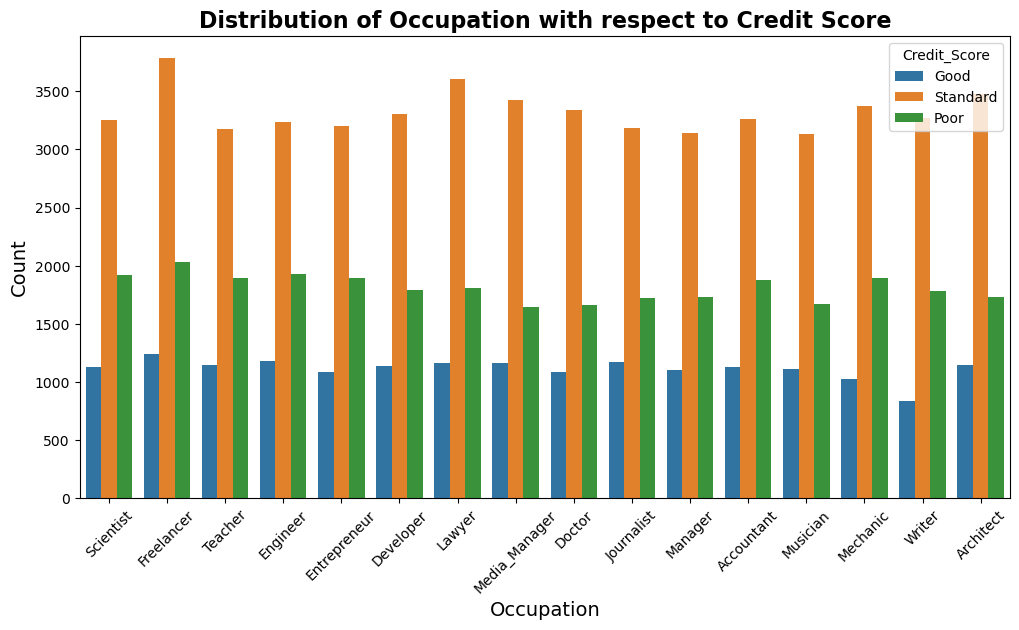

In [294]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='Occupation', hue='Credit_Score')
plt.xticks(rotation=45)
plt.title('Distribution of Occupation with respect to Credit Score', fontdict={'size':16, 'weight':'bold'})
plt.ylabel('Count', fontdict={'size':14})
plt.xlabel('Occupation', fontdict={'size':14})
plt.show()

- From the visualization, we can see the changing the unknown values in Occupation column to 'Freelancer' does not affect the distribution of 'Credit_Score' column and blends in well with the rest.
- We also see that Occupation column has some correlation with the target variable 'Credit_Score' so we keep the column.

In [295]:
Le = LabelEncoder()
df['Occupation_Encoded'] = Le.fit_transform(df['Occupation'])
df.drop('Occupation', axis=1, inplace=True)
df['Occupation_Encoded'].value_counts()

Occupation_Encoded
6     7062
8     6575
1     6355
4     6350
13    6299
10    6291
0     6271
2     6235
11    6232
14    6215
5     6174
3     6087
7     6085
9     5973
12    5911
15    5885
Name: count, dtype: int64

# 4.7. Dropping the columns that are not relevant 1

- We drop the columns that are not relevant.

In [296]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  int64  
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Annual_Income             100000 non-null  object 
 7   Monthly_Inhand_Salary     84998 non-null   float64
 8   Num_Bank_Accounts         100000 non-null  int64  
 9   Num_Credit_Card           100000 non-null  int64  
 10  Interest_Rate             100000 non-null  int64  
 11  Num_of_Loan               100000 non-null  object 
 12  Type_of_Loan              88592 non-null   object 
 13  Delay_from_due_date       100000 non-null  in

In [297]:
cols_to_drop1 = ['Customer_ID', 'Name', 'Age', 'Month', 'SSN']
df.drop(columns=cols_to_drop1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  int64  
 1   Annual_Income             100000 non-null  object 
 2   Monthly_Inhand_Salary     84998 non-null   float64
 3   Num_Bank_Accounts         100000 non-null  int64  
 4   Num_Credit_Card           100000 non-null  int64  
 5   Interest_Rate             100000 non-null  int64  
 6   Num_of_Loan               100000 non-null  object 
 7   Type_of_Loan              88592 non-null   object 
 8   Delay_from_due_date       100000 non-null  int64  
 9   Num_of_Delayed_Payment    92998 non-null   object 
 10  Changed_Credit_Limit      100000 non-null  object 
 11  Num_Credit_Inquiries      98035 non-null   float64
 12  Credit_Mix                100000 non-null  object 
 13  Outstanding_Debt          100000 non-null  ob

# 4.8. Analyzing the Annual Income column

In [298]:
df['Annual_Income'].unique()

array(['19114.12', '34847.84', '34847.84_', ..., '20002.88', '39628.99',
       '39628.99_'], dtype=object)

- Most of the Numbers in Annual Income have a trailing '_' which we need to remove.

In [299]:
df['Annual_Income'] = df['Annual_Income'].str.replace('_', '').astype(float)
df['Annual_Income'].unique()

array([ 19114.12,  34847.84, 143162.64, ...,  37188.1 ,  20002.88,
        39628.99])

In [300]:
df['Annual_Income'] = df['Annual_Income'].astype(float)

- Removed the trailing '_' from Annual Income column and converted the column to float.

# 4.9. Analyzing & Removing outliers in Monthly_Inhand_Salary Column

In [301]:
df['Monthly_Inhand_Salary'].isnull().sum()

np.int64(15002)

In [302]:
df['Monthly_Inhand_Salary'] = df['Monthly_Inhand_Salary'].fillna(df['Monthly_Inhand_Salary'].median())
df['Monthly_Inhand_Salary'].isnull().sum()

np.int64(0)

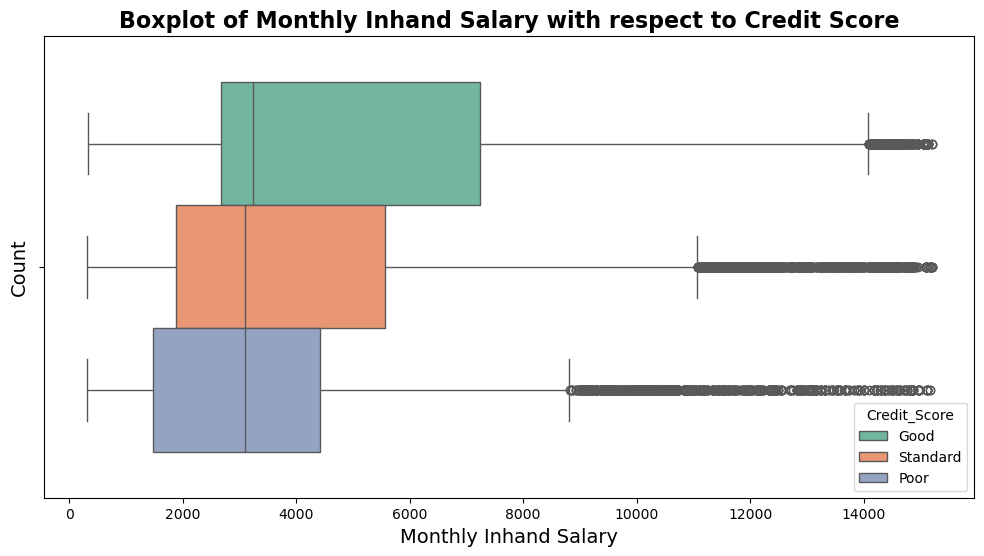

In [303]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='Monthly_Inhand_Salary', hue='Credit_Score', palette='Set2')
plt.title('Boxplot of Monthly Inhand Salary with respect to Credit Score', fontdict={'size':16, 'weight':'bold'})
plt.xlabel('Monthly Inhand Salary', fontdict={'size':14})
plt.ylabel('Count', fontdict={'size':14})
plt.show()

- Removing all extreme outliers using the winsorize method

Original data stats:
count    100000.000000
mean       4029.084964
std        2961.363540
min         303.645417
25%        1792.084167
50%        3093.745000
75%        5371.525000
max       15204.633333
Name: Monthly_Inhand_Salary, dtype: float64

After winsorizing stats:
count    100000.000000
mean       3946.635251
std        2714.753697
min         706.119583
25%        1792.084167
50%        3093.745000
75%        5371.525000
max       12080.516667
Name: Monthly_Inhand_Salary_Winsorized, dtype: float64


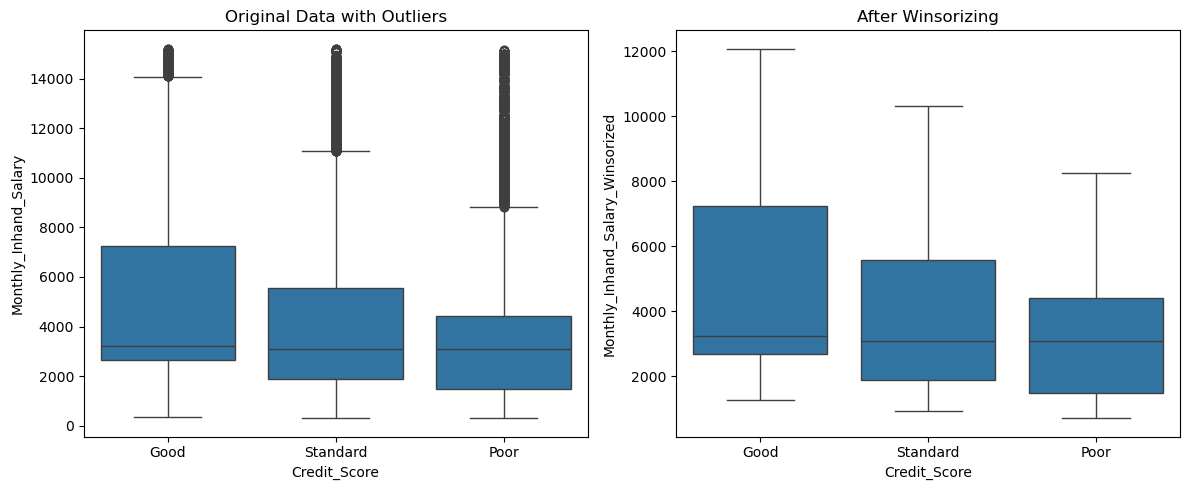

In [304]:
# Winsorize within each credit score group
df['Monthly_Inhand_Salary_Winsorized'] = df.groupby('Credit_Score')['Monthly_Inhand_Salary'].transform(
    lambda x: winsorize(x, limits=[0.05, 0.05])  # Adjust limits as needed
)

# Verify the results
print("Original data stats:")
print(df['Monthly_Inhand_Salary'].describe())
print("\nAfter winsorizing stats:")
print(df['Monthly_Inhand_Salary_Winsorized'].describe())

# Visual comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='Credit_Score', y='Monthly_Inhand_Salary', data=df)
plt.title('Original Data with Outliers')

plt.subplot(1, 2, 2)
sns.boxplot(x='Credit_Score', y='Monthly_Inhand_Salary_Winsorized', data=df)
plt.title('After Winsorizing')

plt.tight_layout()
plt.show()

In [305]:
# Drop the original column
df.drop('Monthly_Inhand_Salary', axis=1, inplace=True)

# 4.10. Number of Bank Accounts

In [306]:
df['Num_Bank_Accounts'].isnull().sum()

np.int64(0)

In [307]:
df['Num_Bank_Accounts'].unique()

array([   3,    2,    1,    7,    4,    0,    8,    5,    6,    9,   10,
       1414, 1231,   67,  572, 1488,   91,  528, 1647, 1696, 1338,  649,
        889, 1668,  685,  857,  975, 1496, 1534, 1620,   37, 1388, 1429,
       1332, 1588,  120, 1777, 1096,  803,  494,  744, 1139,  831, 1613,
        741,  121,  665, 1748, 1644,  823, 1356, 1651,   87,  711,  450,
        210, 1671, 1722,  648,  672, 1662, 1495,  510,  666,  429, 1131,
       1434,  980, 1026,  526,  718, 1300, 1312, 1315,  501, 1566,  480,
       1042,  322,  628, 1016,  333, 1265,  791,  427,  563,  905, 1190,
       1036, 1611,   38,  619,  555, 1769,  280,  752, 1201,  812, 1487,
        222,  212, 1019, 1222,  610, 1714, 1308,  525, 1158, 1115, 1616,
        754, 1601,  797, 1577,  521,  703,  933,  959,  809, 1089, 1656,
       1113, 1715,  964, 1533, 1789,  871,  434, 1295,  565, 1724,  603,
        677,  541,  698, 1101,  464, 1539, 1462, 1011, 1257, 1727,   45,
        244, 1266,  897,  535,  484,  331,  675,  8

In [308]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   ID                                100000 non-null  int64  
 1   Annual_Income                     100000 non-null  float64
 2   Num_Bank_Accounts                 100000 non-null  int64  
 3   Num_Credit_Card                   100000 non-null  int64  
 4   Interest_Rate                     100000 non-null  int64  
 5   Num_of_Loan                       100000 non-null  object 
 6   Type_of_Loan                      88592 non-null   object 
 7   Delay_from_due_date               100000 non-null  int64  
 8   Num_of_Delayed_Payment            92998 non-null   object 
 9   Changed_Credit_Limit              100000 non-null  object 
 10  Num_Credit_Inquiries              98035 non-null   float64
 11  Credit_Mix                        100000 non-null  ob

# 4.11. Analyzing Number of loan and type of loan columns

In [309]:
df['Num_of_Loan'].unique()

array(['4', '1', '3', '967', '-100', '0', '0_', '2', '3_', '2_', '7', '5',
       '5_', '6', '8', '8_', '9', '9_', '4_', '7_', '1_', '1464', '6_',
       '622', '352', '472', '1017', '945', '146', '563', '341', '444',
       '720', '1485', '49', '737', '1106', '466', '728', '313', '843',
       '597_', '617', '119', '663', '640', '92_', '1019', '501', '1302',
       '39', '716', '848', '931', '1214', '186', '424', '1001', '1110',
       '1152', '457', '1433', '1187', '52', '1480', '1047', '1035',
       '1347_', '33', '193', '699', '329', '1451', '484', '132', '649',
       '995', '545', '684', '1135', '1094', '1204', '654', '58', '348',
       '614', '1363', '323', '1406', '1348', '430', '153', '1461', '905',
       '1312', '1424', '1154', '95', '1353', '1228', '819', '1006', '795',
       '359', '1209', '590', '696', '1185_', '1465', '911', '1181', '70',
       '816', '1369', '143', '1416', '455', '55', '1096', '1474', '420',
       '1131', '904', '89', '1259', '527', '1241', '449', 

- Num of loan column has a trailing "_" which we need to remove.

In [310]:
df['Num_of_Loan'] = df['Num_of_Loan'].str.replace('_', '').astype(int)
df['Num_of_Loan'].unique()

array([   4,    1,    3,  967, -100,    0,    2,    7,    5,    6,    8,
          9, 1464,  622,  352,  472, 1017,  945,  146,  563,  341,  444,
        720, 1485,   49,  737, 1106,  466,  728,  313,  843,  597,  617,
        119,  663,  640,   92, 1019,  501, 1302,   39,  716,  848,  931,
       1214,  186,  424, 1001, 1110, 1152,  457, 1433, 1187,   52, 1480,
       1047, 1035, 1347,   33,  193,  699,  329, 1451,  484,  132,  649,
        995,  545,  684, 1135, 1094, 1204,  654,   58,  348,  614, 1363,
        323, 1406, 1348,  430,  153, 1461,  905, 1312, 1424, 1154,   95,
       1353, 1228,  819, 1006,  795,  359, 1209,  590,  696, 1185, 1465,
        911, 1181,   70,  816, 1369,  143, 1416,  455,   55, 1096, 1474,
        420, 1131,  904,   89, 1259,  527, 1241,  449,  983,  418,  319,
         23,  238,  638,  138,  235,  280, 1070, 1484,  274,  494, 1459,
        404, 1354, 1495, 1391,  601, 1313, 1319,  898,  231,  752,  174,
        961, 1046,  834,  284,  438,  288, 1463, 11

In [311]:
df['Type_of_Loan'].unique()

array(['Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan',
       'Credit-Builder Loan', 'Auto Loan, Auto Loan, and Not Specified',
       ..., 'Home Equity Loan, Auto Loan, Auto Loan, and Auto Loan',
       'Payday Loan, Student Loan, Mortgage Loan, and Not Specified',
       'Personal Loan, Auto Loan, Mortgage Loan, Student Loan, and Student Loan'],
      dtype=object)

In [312]:
df['Type_of_Loan'].value_counts()

Type_of_Loan
Not Specified                                                                                        1408
Credit-Builder Loan                                                                                  1280
Personal Loan                                                                                        1272
Debt Consolidation Loan                                                                              1264
Student Loan                                                                                         1240
                                                                                                     ... 
Auto Loan, Payday Loan, Auto Loan, Student Loan, Student Loan, Student Loan, and Home Equity Loan       8
Home Equity Loan, Payday Loan, Not Specified, and Personal Loan                                         8
Home Equity Loan, Auto Loan, Auto Loan, and Auto Loan                                                   8
Payday Loan, Student Loan, Mortga

In [313]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   ID                                100000 non-null  int64  
 1   Annual_Income                     100000 non-null  float64
 2   Num_Bank_Accounts                 100000 non-null  int64  
 3   Num_Credit_Card                   100000 non-null  int64  
 4   Interest_Rate                     100000 non-null  int64  
 5   Num_of_Loan                       100000 non-null  int64  
 6   Type_of_Loan                      88592 non-null   object 
 7   Delay_from_due_date               100000 non-null  int64  
 8   Num_of_Delayed_Payment            92998 non-null   object 
 9   Changed_Credit_Limit              100000 non-null  object 
 10  Num_Credit_Inquiries              98035 non-null   float64
 11  Credit_Mix                        100000 non-null  ob

- Drop type of loan for now.

In [314]:
df.drop(columns=['Type_of_Loan'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   ID                                100000 non-null  int64  
 1   Annual_Income                     100000 non-null  float64
 2   Num_Bank_Accounts                 100000 non-null  int64  
 3   Num_Credit_Card                   100000 non-null  int64  
 4   Interest_Rate                     100000 non-null  int64  
 5   Num_of_Loan                       100000 non-null  int64  
 6   Delay_from_due_date               100000 non-null  int64  
 7   Num_of_Delayed_Payment            92998 non-null   object 
 8   Changed_Credit_Limit              100000 non-null  object 
 9   Num_Credit_Inquiries              98035 non-null   float64
 10  Credit_Mix                        100000 non-null  object 
 11  Outstanding_Debt                  100000 non-null  ob

# 4.12. Num of Delayed payment

In [315]:
df['Num_of_Delayed_Payment'].isnull().sum()

np.int64(7002)

In [316]:
df['Num_of_Delayed_Payment'].unique()

array(['7', nan, '4', '8_', '6', '1', '-1', '3_', '0', '8', '5', '3', '9',
       '12', '15', '17', '10', '2', '2_', '11', '14', '20', '22', '13',
       '13_', '14_', '16', '12_', '18', '19', '23', '24', '21', '3318',
       '3083', '22_', '1338', '4_', '26', '11_', '3104', '21_', '25',
       '10_', '183_', '9_', '1106', '834', '19_', '24_', '17_', '23_',
       '2672', '20_', '2008', '-3', '538', '6_', '1_', '16_', '27', '-2',
       '3478', '2420', '15_', '707', '708', '26_', '18_', '3815', '28',
       '5_', '1867', '2250', '1463', '25_', '7_', '4126', '2882', '1941',
       '2655', '2628', '132', '3069', '306', '0_', '3539', '3684', '1823',
       '4128', '1946', '827', '2297', '2566', '904', '182', '929', '3568',
       '2503', '1552', '2812', '1697', '3764', '851', '3905', '923', '88',
       '1668', '3253', '808', '2689', '3858', '642', '3457', '1402',
       '1732', '3154', '847', '3037', '2204', '3103', '1063', '2056',
       '1282', '1841', '2569_', '211', '793', '3484', '4

- We see that the column has negative numbers and a trailing "_" which we need to remove.

In [317]:
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].str.replace('_', '')
df['Num_of_Delayed_Payment'].unique()

array(['7', nan, '4', '8', '6', '1', '-1', '3', '0', '5', '9', '12', '15',
       '17', '10', '2', '11', '14', '20', '22', '13', '16', '18', '19',
       '23', '24', '21', '3318', '3083', '1338', '26', '3104', '25',
       '183', '1106', '834', '2672', '2008', '-3', '538', '27', '-2',
       '3478', '2420', '707', '708', '3815', '28', '1867', '2250', '1463',
       '4126', '2882', '1941', '2655', '2628', '132', '3069', '306',
       '3539', '3684', '1823', '4128', '1946', '827', '2297', '2566',
       '904', '182', '929', '3568', '2503', '1552', '2812', '1697',
       '3764', '851', '3905', '923', '88', '1668', '3253', '808', '2689',
       '3858', '642', '3457', '1402', '1732', '3154', '847', '3037',
       '2204', '3103', '1063', '2056', '1282', '1841', '2569', '211',
       '793', '3484', '411', '3491', '2072', '3050', '1049', '2162',
       '3402', '2753', '1718', '1014', '3260', '3855', '84', '2311',
       '3251', '1832', '4069', '3010', '733', '4241', '166', '2461',
       '1749

In [318]:
# Replace Nan with 0
df['Num_of_Delayed_Payment'].fillna(0, inplace=True)
df['Num_of_Delayed_Payment'].unique()

C:\Users\basel\AppData\Local\Temp\ipykernel_5336\4241038995.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Num_of_Delayed_Payment'].fillna(0, inplace=True)


array(['7', 0, '4', '8', '6', '1', '-1', '3', '0', '5', '9', '12', '15',
       '17', '10', '2', '11', '14', '20', '22', '13', '16', '18', '19',
       '23', '24', '21', '3318', '3083', '1338', '26', '3104', '25',
       '183', '1106', '834', '2672', '2008', '-3', '538', '27', '-2',
       '3478', '2420', '707', '708', '3815', '28', '1867', '2250', '1463',
       '4126', '2882', '1941', '2655', '2628', '132', '3069', '306',
       '3539', '3684', '1823', '4128', '1946', '827', '2297', '2566',
       '904', '182', '929', '3568', '2503', '1552', '2812', '1697',
       '3764', '851', '3905', '923', '88', '1668', '3253', '808', '2689',
       '3858', '642', '3457', '1402', '1732', '3154', '847', '3037',
       '2204', '3103', '1063', '2056', '1282', '1841', '2569', '211',
       '793', '3484', '411', '3491', '2072', '3050', '1049', '2162',
       '3402', '2753', '1718', '1014', '3260', '3855', '84', '2311',
       '3251', '1832', '4069', '3010', '733', '4241', '166', '2461',
       '1749',

In [319]:
# Replace negative values with 0
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].astype(int)
df.loc[df['Num_of_Delayed_Payment'] < 0, 'Num_of_Delayed_Payment'] = 0
df['Num_of_Delayed_Payment'].unique()

array([   7,    0,    4,    8,    6,    1,    3,    5,    9,   12,   15,
         17,   10,    2,   11,   14,   20,   22,   13,   16,   18,   19,
         23,   24,   21, 3318, 3083, 1338,   26, 3104,   25,  183, 1106,
        834, 2672, 2008,  538,   27, 3478, 2420,  707,  708, 3815,   28,
       1867, 2250, 1463, 4126, 2882, 1941, 2655, 2628,  132, 3069,  306,
       3539, 3684, 1823, 4128, 1946,  827, 2297, 2566,  904,  182,  929,
       3568, 2503, 1552, 2812, 1697, 3764,  851, 3905,  923,   88, 1668,
       3253,  808, 2689, 3858,  642, 3457, 1402, 1732, 3154,  847, 3037,
       2204, 3103, 1063, 2056, 1282, 1841, 2569,  211,  793, 3484,  411,
       3491, 2072, 3050, 1049, 2162, 3402, 2753, 1718, 1014, 3260, 3855,
         84, 2311, 3251, 1832, 4069, 3010,  733, 4241,  166, 2461, 1749,
       3200,  663, 2185, 4161, 3009,  359, 2015, 1523,  594, 1079, 1199,
        186, 1015, 1989,  281,  559, 2165, 1509, 3545,  779,  192, 4311,
       2323, 1471, 1538, 3529,  439, 3456, 3040, 26

- We fixed the null values and negative values in the Num of delayed payment column.

# 4.13. Checking credit limit

In [320]:
df['Changed_Credit_Limit'].unique()

array(['11.27', '_', '6.27', ..., '17.509999999999998', '25.16', '21.17'],
      dtype=object)

In [321]:
# Change '_' with 0
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].str.replace('_', '0')
df['Changed_Credit_Limit'].unique()

array(['11.27', '0', '6.27', ..., '17.509999999999998', '25.16', '21.17'],
      dtype=object)

In [322]:
# Counting how much '_' is in the column
df['Changed_Credit_Limit'].value_counts()

Changed_Credit_Limit
0                    2091
8.22                  133
11.5                  127
11.32                 126
7.35                  121
                     ... 
30.16                   1
4.710000000000001       1
-4.39                   1
27.38                   1
16.63                   1
Name: count, Length: 4384, dtype: int64

In [323]:
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].astype(float)
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].replace(0, df['Changed_Credit_Limit'].median())
df['Changed_Credit_Limit'].unique()

array([11.27,  9.25,  6.27, ..., 17.51, 25.16, 21.17])

In [324]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   ID                                100000 non-null  int64  
 1   Annual_Income                     100000 non-null  float64
 2   Num_Bank_Accounts                 100000 non-null  int64  
 3   Num_Credit_Card                   100000 non-null  int64  
 4   Interest_Rate                     100000 non-null  int64  
 5   Num_of_Loan                       100000 non-null  int64  
 6   Delay_from_due_date               100000 non-null  int64  
 7   Num_of_Delayed_Payment            100000 non-null  int64  
 8   Changed_Credit_Limit              100000 non-null  float64
 9   Num_Credit_Inquiries              98035 non-null   float64
 10  Credit_Mix                        100000 non-null  object 
 11  Outstanding_Debt                  100000 non-null  ob

# 4.14. Number of credit inquiries

In [325]:
df['Num_Credit_Inquiries'].isnull().sum()

np.int64(1965)

In [326]:
df['Num_Credit_Inquiries'] = df['Num_Credit_Inquiries'].fillna(df['Num_Credit_Inquiries'].median())
df['Num_Credit_Inquiries'].isnull().sum()

np.int64(0)

# 4.15. Credit Mix column

- Credit Mix column is important in determining the credit score of a customer.

In [327]:
df['Credit_Mix'].value_counts()

Credit_Mix
Standard    36479
Good        24337
_           20195
Bad         18989
Name: count, dtype: int64

In [328]:
# Manual ordinal encoding based on credit quality
credit_mix_order = {
    'Bad': 0,
    'Standard': 1, 
    'Good': 2,
    'Unknown': 1,  # Treat unknown as standard
    '_': 1         # Same for underscore
}

df['Credit_Mix_Encoded'] = df['Credit_Mix'].map(credit_mix_order)
df['Credit_Mix_Encoded'].value_counts()

Credit_Mix_Encoded
1    56674
2    24337
0    18989
Name: count, dtype: int64

- This way, we encoded the credit mix column efficiently to fit the model well with no risk of overfitting or being resource intensive.
- We treated '_' and 'standard' as the same value for 1, 'Bad' for 0, and 'Good' for 2.

In [329]:
df.drop(columns=['Credit_Mix'], inplace=True)

In [330]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   ID                                100000 non-null  int64  
 1   Annual_Income                     100000 non-null  float64
 2   Num_Bank_Accounts                 100000 non-null  int64  
 3   Num_Credit_Card                   100000 non-null  int64  
 4   Interest_Rate                     100000 non-null  int64  
 5   Num_of_Loan                       100000 non-null  int64  
 6   Delay_from_due_date               100000 non-null  int64  
 7   Num_of_Delayed_Payment            100000 non-null  int64  
 8   Changed_Credit_Limit              100000 non-null  float64
 9   Num_Credit_Inquiries              100000 non-null  float64
 10  Outstanding_Debt                  100000 non-null  object 
 11  Credit_Utilization_Ratio          100000 non-null  fl

# 4.16. Outstanding debt column

- Outstanding debt column also has a trailing "_" which we need to remove.

In [331]:
df['Outstanding_Debt'].unique()

array(['809.98', '605.03', '1303.01', ..., '3571.7_', '3571.7', '502.38'],
      dtype=object)

In [332]:
df['Outstanding_Debt'] = df['Outstanding_Debt'].str.replace('_', '').astype(float)
df['Outstanding_Debt'].unique()

array([ 809.98,  605.03, 1303.01, ...,  620.64, 3571.7 ,  502.38])

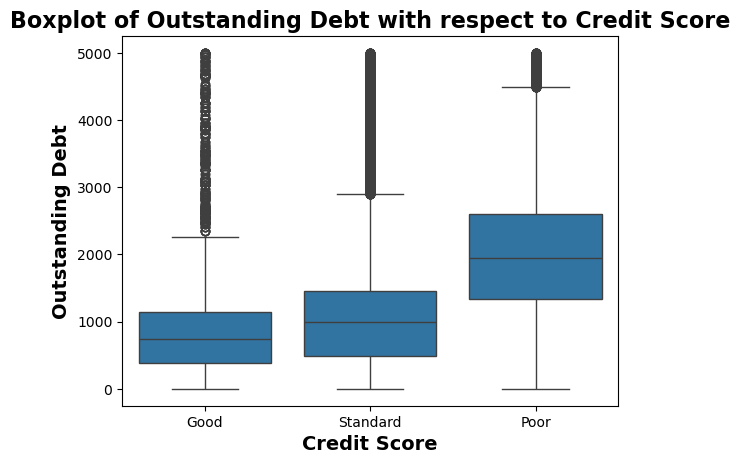

In [333]:
plt.Figure(figsize=(12, 6))
sns.boxplot(x='Credit_Score', y='Outstanding_Debt', data=df)
plt.title('Boxplot of Outstanding Debt with respect to Credit Score', fontdict={'size':16, 'weight':'bold'})
plt.xlabel('Credit Score', fontdict={'size':14, 'weight':'bold'})
plt.ylabel('Outstanding Debt', fontdict={'size':14, 'weight':'bold'})
plt.show()

- Winsorize outliers

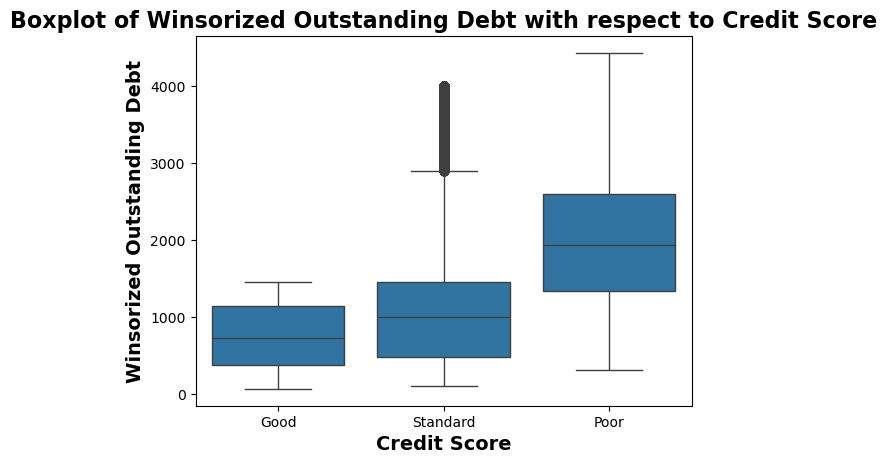

In [334]:
# Winsorize within each credit score group
df['Outstanding_Debt_Winsorized'] = df.groupby('Credit_Score')['Outstanding_Debt'].transform(
    lambda x: winsorize(x, limits=[0.05, 0.05])  # Adjust limits as needed
)

# Plot the new column data
plt.Figure(figsize=(12, 6))
sns.boxplot(x='Credit_Score', y='Outstanding_Debt_Winsorized', data=df)
plt.title('Boxplot of Winsorized Outstanding Debt with respect to Credit Score', fontdict={'size':16, 'weight':'bold'})
plt.xlabel('Credit Score', fontdict={'size':14, 'weight':'bold'})
plt.ylabel('Winsorized Outstanding Debt', fontdict={'size':14, 'weight':'bold'})
plt.show()

- Drop the original column and print info

In [335]:
df.drop(columns=['Outstanding_Debt'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   ID                                100000 non-null  int64  
 1   Annual_Income                     100000 non-null  float64
 2   Num_Bank_Accounts                 100000 non-null  int64  
 3   Num_Credit_Card                   100000 non-null  int64  
 4   Interest_Rate                     100000 non-null  int64  
 5   Num_of_Loan                       100000 non-null  int64  
 6   Delay_from_due_date               100000 non-null  int64  
 7   Num_of_Delayed_Payment            100000 non-null  int64  
 8   Changed_Credit_Limit              100000 non-null  float64
 9   Num_Credit_Inquiries              100000 non-null  float64
 10  Credit_Utilization_Ratio          100000 non-null  float64
 11  Credit_History_Age                90970 non-null   ob

# 4.17. Credit History age column

In [336]:
df['Credit_History_Age'].isnull().sum()

np.int64(9030)

- Replacing NaN Values with 1 year.

In [337]:
df['Credit_History_Age'] = df['Credit_History_Age'].fillna('0 Years and 0 Months')
df['Credit_History_Age'].isnull().sum()

np.int64(0)

In [338]:
df['Credit_History_Age'].value_counts()

Credit_History_Age
0 Years and 0 Months      9030
15 Years and 11 Months     446
19 Years and 4 Months      445
19 Years and 5 Months      444
17 Years and 11 Months     443
                          ... 
0 Years and 3 Months        20
0 Years and 2 Months        15
33 Years and 7 Months       14
33 Years and 8 Months       12
0 Years and 1 Months         2
Name: count, Length: 405, dtype: int64

- Replace only with the number of years instead.

In [339]:
# Split at space
df['Credit_History_Age'] = df['Credit_History_Age'].str.split(' ').str[0].astype(int)
df['Credit_History_Age'].value_counts()

Credit_History_Age
0     9520
19    4784
18    4747
17    4718
16    4526
15    3854
20    3325
6     3054
13    3048
30    2982
32    2899
8     2814
29    2812
9     2803
31    2799
12    2790
23    2789
28    2767
24    2764
26    2727
22    2721
21    2708
11    2703
27    2622
10    2618
7     2575
25    2522
14    2360
5     2033
33    1106
1     1001
2      938
3      809
4      762
Name: count, dtype: int64

- Replacing 0 with 1 and renaming the column to 'Credit_History_Years'

In [340]:
df['Credit_History_Age'] = df['Credit_History_Age'].replace(0, 1)
df['Credit_History_Age'].value_counts()

Credit_History_Age
1     10521
19     4784
18     4747
17     4718
16     4526
15     3854
20     3325
6      3054
13     3048
30     2982
32     2899
8      2814
29     2812
9      2803
31     2799
12     2790
23     2789
28     2767
24     2764
26     2727
22     2721
21     2708
11     2703
27     2622
10     2618
7      2575
25     2522
14     2360
5      2033
33     1106
2       938
3       809
4       762
Name: count, dtype: int64

# 4.18. Payment of min amount

In [341]:
df['Payment_of_Min_Amount'].value_counts()

Payment_of_Min_Amount
Yes    52326
No     35667
NM     12007
Name: count, dtype: int64

- Encode the column using Label Encoding

In [342]:
# Label Encode the column
label_en = LabelEncoder()
df['Payment_of_Min_Amount'] = label_en.fit_transform(df['Payment_of_Min_Amount'])
df['Payment_of_Min_Amount'].value_counts()

Payment_of_Min_Amount
2    52326
1    35667
0    12007
Name: count, dtype: int64

In [343]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   ID                                100000 non-null  int64  
 1   Annual_Income                     100000 non-null  float64
 2   Num_Bank_Accounts                 100000 non-null  int64  
 3   Num_Credit_Card                   100000 non-null  int64  
 4   Interest_Rate                     100000 non-null  int64  
 5   Num_of_Loan                       100000 non-null  int64  
 6   Delay_from_due_date               100000 non-null  int64  
 7   Num_of_Delayed_Payment            100000 non-null  int64  
 8   Changed_Credit_Limit              100000 non-null  float64
 9   Num_Credit_Inquiries              100000 non-null  float64
 10  Credit_Utilization_Ratio          100000 non-null  float64
 11  Credit_History_Age                100000 non-null  in

# 4.19. Total EMI per month

In [344]:
df['Total_EMI_per_month'].value_counts()

Total_EMI_per_month
0.000000        10613
31.086195           8
149.897199          8
62.222285           8
171.430198          8
                ...  
33746.000000        1
39347.000000        1
27292.000000        1
16627.000000        1
49430.000000        1
Name: count, Length: 14950, dtype: int64

- For now we leave the Total EMI per month column as is.

# 4.20. Amount invested monthly

In [345]:
df['Amount_invested_monthly'].value_counts()

Amount_invested_monthly
__10000__             4305
0.0                    169
167.1638651610451        1
80.41529543900253        1
118.28022162236736       1
                      ... 
215.48638555294247       1
78.49772657092517        1
147.33990786653956       1
82.82557214415213        1
42.935565846112745       1
Name: count, Length: 91049, dtype: int64

- Replace all '_' with empty string.

- Cleaning all the weird values and otherwise non numerical values in the column.

In [346]:
def robust_clean_investment(value):
    if pd.isna(value):
        return np.nan
    
    value_str = str(value).strip()
    
    # Common patterns to handle
    patterns = [
        (r'>\s*(\d+)', lambda x: int(x) + 1),           # >100 → 101
        (r'>=\s*(\d+)', lambda x: int(x)),               # >=100 → 100
        (r'<=\s*(\d+)', lambda x: int(x)),               # <=100 → 100
        (r'<\s*(\d+)', lambda x: int(x) - 1),            # <100 → 99
        (r'(\d+)\s*_', lambda x: int(x)),                # 100_ → 100
        (r'_(\d+)', lambda x: int(x)),                   # _100 → 100
        (r'(\d+)\s*-\s*(\d+)', lambda x, y: (int(x) + int(y)) / 2),  # 100-200 → 150
    ]
    
    # Try each pattern
    for pattern, converter in patterns:
        match = re.search(pattern, value_str)
        if match:
            try:
                return converter(*match.groups())
            except:
                continue
    
    # Try to extract any numbers
    numbers = re.findall(r'\d+', value_str)
    if numbers:
        return float(numbers[0])  # Take the first number found
    
    return np.nan

# Apply the robust cleaning
df['Amount_Invested_Monthly_Clean'] = df['Amount_invested_monthly'].apply(robust_clean_investment)

In [347]:
df.drop(columns=['Amount_invested_monthly'], inplace=True)

In [348]:
df['Amount_Invested_Monthly_Clean'] = df['Amount_Invested_Monthly_Clean'].replace(np.nan, df['Amount_Invested_Monthly_Clean'].mean())
df['Amount_Invested_Monthly_Clean'] = df['Amount_Invested_Monthly_Clean'].astype(int)
df['Amount_Invested_Monthly_Clean'].value_counts()

Amount_Invested_Monthly_Clean
636      4495
10000    4305
54        506
62        506
65        498
         ... 
1202        1
1785        1
1340        1
1018        1
1637        1
Name: count, Length: 1416, dtype: int64

# 4.21. Payment Behaviour

In [349]:
df['Payment_Behaviour'].value_counts()

Payment_Behaviour
Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
!@9#%8                               7600
Name: count, dtype: int64

- Unknown or Missing values marked as '!@9#%8'.
- We will replace these with the standard which in this case is 'Low_spent_Small_value_payments'.

In [350]:
df['Payment_Behaviour'] = df['Payment_Behaviour'].replace('!@9#%8', 'Low_spent_Small_value_payments')
df['Payment_Behaviour'].value_counts()

Payment_Behaviour
Low_spent_Small_value_payments      33113
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
Name: count, dtype: int64

- We implement Label Encoding and create a new encoded column while dropping the previous original column.

In [351]:
le = LabelEncoder()
df['Payment_Behaviour_Encoded'] = le.fit_transform(df['Payment_Behaviour'])
df.drop(columns=['Payment_Behaviour'], inplace=True)
df['Payment_Behaviour_Encoded'].value_counts()

Payment_Behaviour_Encoded
5    33113
1    17540
4    13861
0    13721
2    11340
3    10425
Name: count, dtype: int64

# 4.22. Monthly Balance

In [352]:
df['Monthly_Balance'].isnull().sum()

np.int64(1200)

In [353]:
df['Monthly_Balance'].unique()

array(['312.49408867943663', '284.62916249607184', '331.2098628537912',
       ..., 516.8090832742814, 319.1649785257098, 393.6736955618808],
      dtype=object)

- Implement same cleaning cycle with the Monthly Balance column.

In [354]:
def robust_clean_investment(value):
    if pd.isna(value):
        return np.nan
    
    value_str = str(value).strip()
    
    # Common patterns to handle
    patterns = [
        (r'>\s*(\d+)', lambda x: int(x) + 1),           # >100 → 101
        (r'>=\s*(\d+)', lambda x: int(x)),               # >=100 → 100
        (r'<=\s*(\d+)', lambda x: int(x)),               # <=100 → 100
        (r'<\s*(\d+)', lambda x: int(x) - 1),            # <100 → 99
        (r'(\d+)\s*_', lambda x: int(x)),                # 100_ → 100
        (r'_(\d+)', lambda x: int(x)),                   # _100 → 100
        (r'(\d+)\s*-\s*(\d+)', lambda x, y: (int(x) + int(y)) / 2),  # 100-200 → 150
    ]
    
    # Try each pattern
    for pattern, converter in patterns:
        match = re.search(pattern, value_str)
        if match:
            try:
                return converter(*match.groups())
            except:
                continue
    
    # Try to extract any numbers
    numbers = re.findall(r'\d+', value_str)
    if numbers:
        return float(numbers[0])  # Take the first number found
    
    return np.nan

# Apply the robust cleaning
df['Monthly_Balance_Cleaned'] = df['Monthly_Balance'].apply(robust_clean_investment)

In [355]:
df['Monthly_Balance_Cleaned'] = df['Monthly_Balance_Cleaned'].replace(np.nan, df['Monthly_Balance_Cleaned'].mean())
df['Monthly_Balance_Cleaned'] = df['Monthly_Balance_Cleaned'].astype(float)
df['Monthly_Balance_Cleaned'].unique()

array([ 312.,  284.,  331., ..., 1411., 1299., 1295.])

In [356]:
df.drop(columns=['Monthly_Balance'], inplace=True)

# 4.23. Finally, Target Column 'Credit_Score'

In [357]:
df['Credit_Score'].value_counts()

Credit_Score
Standard    53174
Poor        28998
Good        17828
Name: count, dtype: int64

- Label Encode the Final Credit Score Column

In [358]:
# Create a mapping dictionary
credit_score_mapping = {'Poor': 0, 'Standard': 1, 'Good': 2}

# Apply the mapping
df['Credit_Score_Encoded'] = df['Credit_Score'].map(credit_score_mapping)

- After Encoding the final credit score column, we drop the original column and procced with the Model.

In [359]:
df.drop(columns=['Credit_Score'], inplace=True)
df['Credit_Score_Encoded'].value_counts()

Credit_Score_Encoded
1    53174
0    28998
2    17828
Name: count, dtype: int64

# 5. Conclusion

- Saving the new cleaned dataset as a CSV file.
- We can now proceed to the Model Building stage.

In [360]:
df.to_csv('Dataset/cleaned_dataset.csv', index=False)

In [361]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   ID                                100000 non-null  int64  
 1   Annual_Income                     100000 non-null  float64
 2   Num_Bank_Accounts                 100000 non-null  int64  
 3   Num_Credit_Card                   100000 non-null  int64  
 4   Interest_Rate                     100000 non-null  int64  
 5   Num_of_Loan                       100000 non-null  int64  
 6   Delay_from_due_date               100000 non-null  int64  
 7   Num_of_Delayed_Payment            100000 non-null  int64  
 8   Changed_Credit_Limit              100000 non-null  float64
 9   Num_Credit_Inquiries              100000 non-null  float64
 10  Credit_Utilization_Ratio          100000 non-null  float64
 11  Credit_History_Age                100000 non-null  in

In [362]:
# Check count of numerical columns
df.select_dtypes(include=['int64', 'float64']).count()

ID                                  100000
Annual_Income                       100000
Num_Bank_Accounts                   100000
Num_Credit_Card                     100000
Interest_Rate                       100000
Num_of_Loan                         100000
Delay_from_due_date                 100000
Num_of_Delayed_Payment              100000
Changed_Credit_Limit                100000
Num_Credit_Inquiries                100000
Credit_Utilization_Ratio            100000
Credit_History_Age                  100000
Payment_of_Min_Amount               100000
Total_EMI_per_month                 100000
Occupation_Encoded                  100000
Monthly_Inhand_Salary_Winsorized    100000
Credit_Mix_Encoded                  100000
Outstanding_Debt_Winsorized         100000
Amount_Invested_Monthly_Clean       100000
Payment_Behaviour_Encoded           100000
Monthly_Balance_Cleaned             100000
Credit_Score_Encoded                100000
dtype: int64

In this EDA file, we've cleaned the dataset and prepared it for the model building phase.
1. Cleaned all columns from missing values.
2. Removed non-essential columns.
3. Handled outliers in more than one column by using winsorization.
4. Encoded all categorical columns using Label & Conventional Encoding.
5. Saved the cleaned dataset as a CSV file for further model training.